In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as prog_bar

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.callbacks import ModelCheckpoint

### Random States
---

In [8]:
random_states =( 10,13,17,24,51)

In [9]:
cg = ('a','b','c','d') #categories

In [10]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Train_Test_Data_Splits')
TTS_Folder_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_Folder_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['train_test_rs_10', 'train_test_rs_13', 'train_test_rs_17', 'train_test_rs_24', 'train_test_rs_51']


In [21]:
def get_train_test_xy():
    

    for tts_foldr in TTS_Folder_LIST:
        OHEs = {}
        Scalers = {}
        for x in cg:
            Scalers[x] = StandardScaler()
            OHEs[x] = OneHotEncoder()
        
        x_trains = {}
        y_trains= {}
        x_tests = {}
        y_tests = {}
        TTS_FILE_LIST = os.listdir(os.path.join(TTS_BASE_DIR,tts_foldr))
        for tts_file in TTS_FILE_LIST:
            tts_file_path = os.path.join(TTS_BASE_DIR,tts_foldr,tts_file)
            df = pd.read_csv(tts_file_path,index_col=False)
            tts_file_wo_ext = tts_file.split('.')[0].split('_')
            k = TTS_DICT_INV[tts_file_wo_ext[-1]]
            if 'train' in tts_file_wo_ext:
                #depend on test set size
                x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_trains[k] = np.expand_dims(x_trains[k], axis=2)
                y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
            else:
                x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_tests[k] = np.expand_dims(x_tests[k], axis=2)
                y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
        r_state = tts_foldr.split("_")[-1]
        yield (x_trains,y_trains,x_tests,y_tests,r_state)    
            
        

In [40]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    acc = model.evaluate(x_test,y_test)[1]*100
    print(f"Accuracy of our model on test data :{acc:.2f} %")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()
    return acc

---
### Base Model Folder path
----

In [28]:
MODEL_BASE_DIR = os.path.abspath('Models')

---
## Model 1
----

In [31]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [41]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1'))

In [61]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 35

In [62]:
model_1_acc_matrix = {}
for k in cg:
   model_1_acc_matrix[k]= list()
print(model_1_acc_matrix) 
 

{'a': [], 'b': [], 'c': [], 'd': []}


  0%|          | 0/5 [00:00<?, ?it/s]

Random State : = 10
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 3s 60ms/step - loss: 1.9290 - accuracy: 0.2340 - val_loss: 1.7673 - val_accuracy: 0.3333
Epoch 2/35
41/41 [==============================] - 2s 53ms/step - loss: 1.7751 - accuracy: 0.3284 - val_loss: 1.6505 - val_accuracy: 0.3722
Epoch 3/35
41/41 [==============================] - 1s 30ms/step - loss: 1.7028 - accuracy: 0.3630 - val_loss: 1.5668 - val_accuracy: 0.4056
Epoch 4/35
41/41 [==============================] - 2s 46ms/step - loss: 1.5725 - accuracy: 0.3889 - val_loss: 1.4882 - val_accuracy: 0.4222
Epoch 5/35
41/41 [==============================] - 1s 23ms/step - loss: 1.5096 - accuracy: 0.4265 - val_loss: 1.4452 - val_accuracy: 0.4685
Epoch 6/35
41/41 [==============================] - 1s 22ms/step - loss: 1.4479 - accuracy: 0.4512 - val_loss: 1.4

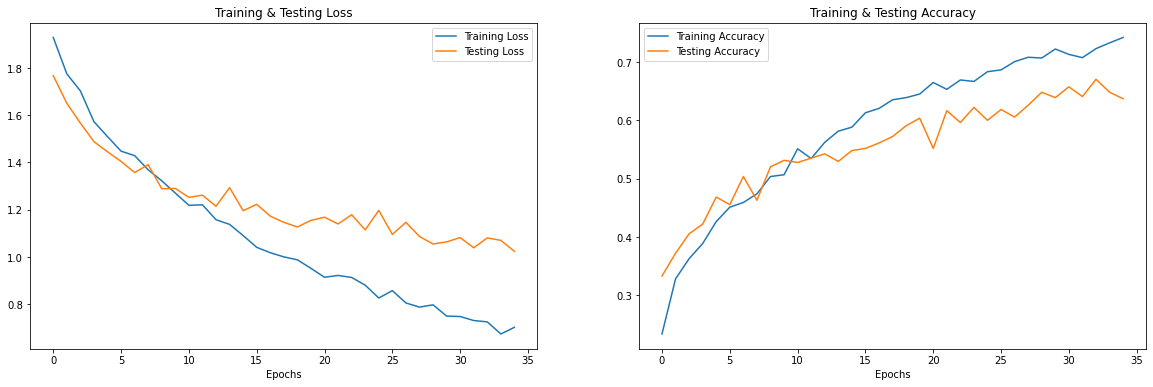

Random State : = 10
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 3s 53ms/step - loss: 1.9209 - accuracy: 0.2464 - val_loss: 1.7295 - val_accuracy: 0.3719
Epoch 2/35
49/49 [==============================] - 3s 58ms/step - loss: 1.7381 - accuracy: 0.3302 - val_loss: 1.6039 - val_accuracy: 0.4012
Epoch 3/35
49/49 [==============================] - 3s 57ms/step - loss: 1.6621 - accuracy: 0.3632 - val_loss: 1.5274 - val_accuracy: 0.4043
Epoch 4/35
49/49 [==============================] - 3s 54ms/step - loss: 1.5888 - accuracy: 0.3884 - val_loss: 1.5228 - val_accuracy: 0.3966
Epoch 5/35
49/49 [==============================] - 2s 44ms/step - loss: 1.5262 - accuracy: 0.4295 - val_loss: 1.4212 - val_accuracy: 0.4552
Epoch 6/35
49/49 [==============================] - 1s 21ms/step - loss: 1.4793 - accuracy: 0.4408 - val_loss: 1.3

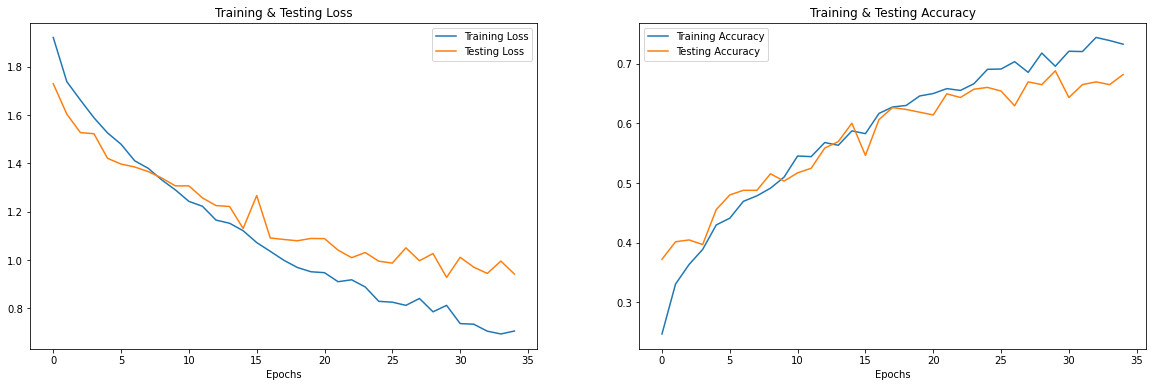

Random State : = 10
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 3s 48ms/step - loss: 1.9438 - accuracy: 0.2243 - val_loss: 1.8115 - val_accuracy: 0.3123
Epoch 2/35
61/61 [==============================] - 1s 23ms/step - loss: 1.8292 - accuracy: 0.2979 - val_loss: 1.6896 - val_accuracy: 0.3432
Epoch 3/35
61/61 [==============================] - 1s 23ms/step - loss: 1.7288 - accuracy: 0.3494 - val_loss: 1.6269 - val_accuracy: 0.4062
Epoch 4/35
61/61 [==============================] - 1s 23ms/step - loss: 1.6381 - accuracy: 0.3815 - val_loss: 1.5069 - val_accuracy: 0.4259
Epoch 5/35
61/61 [==============================] - 1s 23ms/step - loss: 1.5643 - accuracy: 0.3984 - val_loss: 1.4616 - val_accuracy: 0.4383
Epoch 6/35
61/61 [==============================] - 1s 23ms/step - loss: 1.5172 - accuracy: 0.4103 - val_loss: 1.4

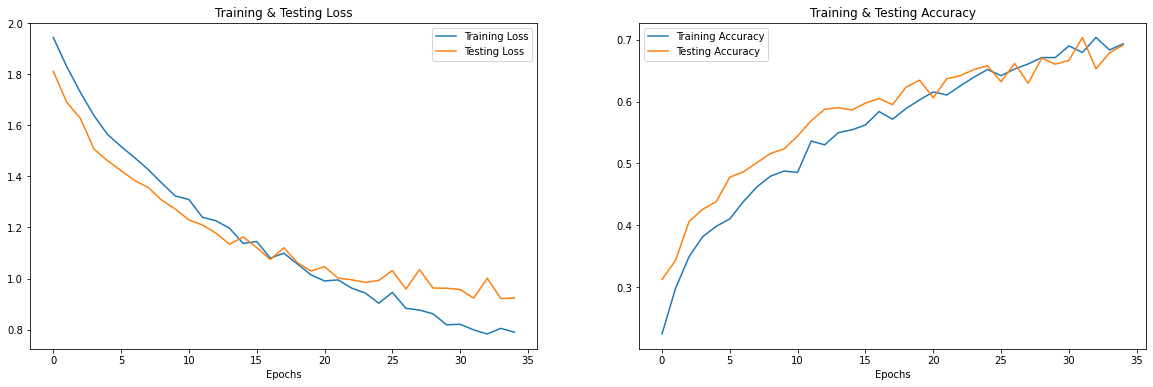

Random State : = 10
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 2s 31ms/step - loss: 1.9240 - accuracy: 0.2330 - val_loss: 1.7441 - val_accuracy: 0.3588
Epoch 2/35
65/65 [==============================] - 4s 56ms/step - loss: 1.7745 - accuracy: 0.3245 - val_loss: 1.6294 - val_accuracy: 0.3854
Epoch 3/35
65/65 [==============================] - 3s 50ms/step - loss: 1.6782 - accuracy: 0.3673 - val_loss: 1.5465 - val_accuracy: 0.4051
Epoch 4/35
65/65 [==============================] - 3s 53ms/step - loss: 1.5951 - accuracy: 0.3746 - val_loss: 1.4799 - val_accuracy: 0.4248
Epoch 5/35
65/65 [==============================] - 3s 53ms/step - loss: 1.5428 - accuracy: 0.4051 - val_loss: 1.4183 - val_accuracy: 0.4722
Epoch 6/35
65/65 [==============================] - 3s 43ms/step - loss: 1.4616 - accuracy: 0.4290 - val_loss: 1.3

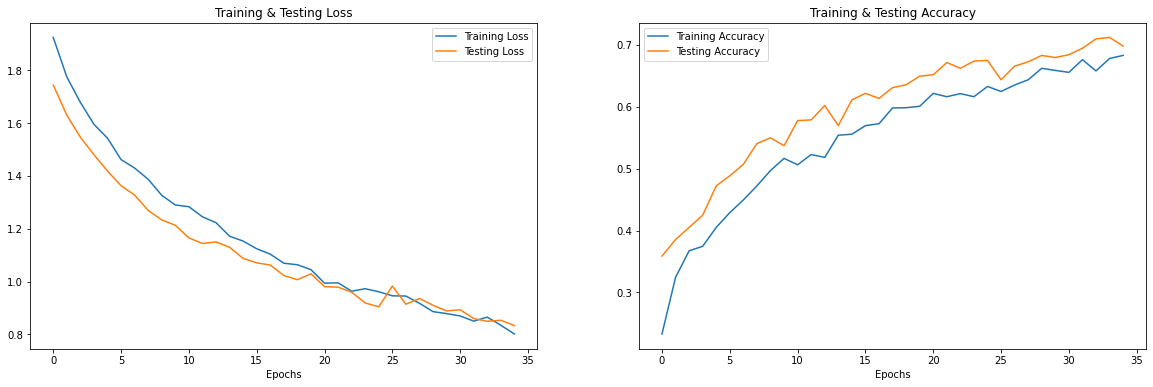

Random State : = 13
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 3s 55ms/step - loss: 1.9352 - accuracy: 0.2228 - val_loss: 1.8840 - val_accuracy: 0.3093
Epoch 2/35
41/41 [==============================] - 2s 50ms/step - loss: 1.8123 - accuracy: 0.3012 - val_loss: 1.7162 - val_accuracy: 0.3648
Epoch 3/35
41/41 [==============================] - 1s 26ms/step - loss: 1.7178 - accuracy: 0.3309 - val_loss: 1.6553 - val_accuracy: 0.4074
Epoch 4/35
41/41 [==============================] - 1s 24ms/step - loss: 1.6602 - accuracy: 0.3580 - val_loss: 1.6121 - val_accuracy: 0.3852
Epoch 5/35
41/41 [==============================] - 1s 29ms/step - loss: 1.6029 - accuracy: 0.3765 - val_loss: 1.5293 - val_accuracy: 0.4407
Epoch 6/35
41/41 [==============================] - 1s 32ms/step - loss: 1.5528 - accuracy: 0.4043 - val_loss: 1.4

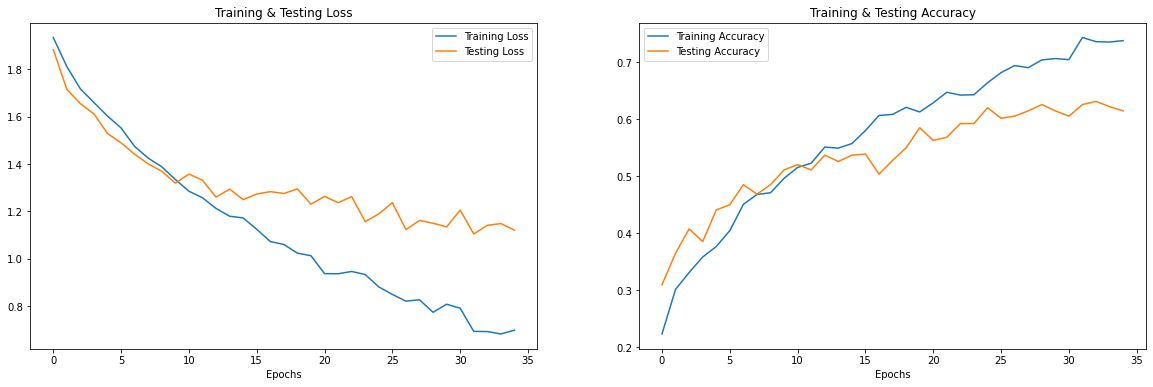

Random State : = 13
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 30ms/step - loss: 1.9119 - accuracy: 0.2572 - val_loss: 1.7427 - val_accuracy: 0.3549
Epoch 2/35
49/49 [==============================] - 2s 43ms/step - loss: 1.7438 - accuracy: 0.3385 - val_loss: 1.6140 - val_accuracy: 0.3657
Epoch 3/35
49/49 [==============================] - 1s 23ms/step - loss: 1.7021 - accuracy: 0.3421 - val_loss: 1.6149 - val_accuracy: 0.3549
Epoch 4/35
49/49 [==============================] - 2s 34ms/step - loss: 1.6192 - accuracy: 0.3745 - val_loss: 1.4828 - val_accuracy: 0.4290
Epoch 5/35
49/49 [==============================] - 2s 38ms/step - loss: 1.5597 - accuracy: 0.4053 - val_loss: 1.4491 - val_accuracy: 0.4275
Epoch 6/35
49/49 [==============================] - 1s 26ms/step - loss: 1.4910 - accuracy: 0.4321 - val_loss: 1.3

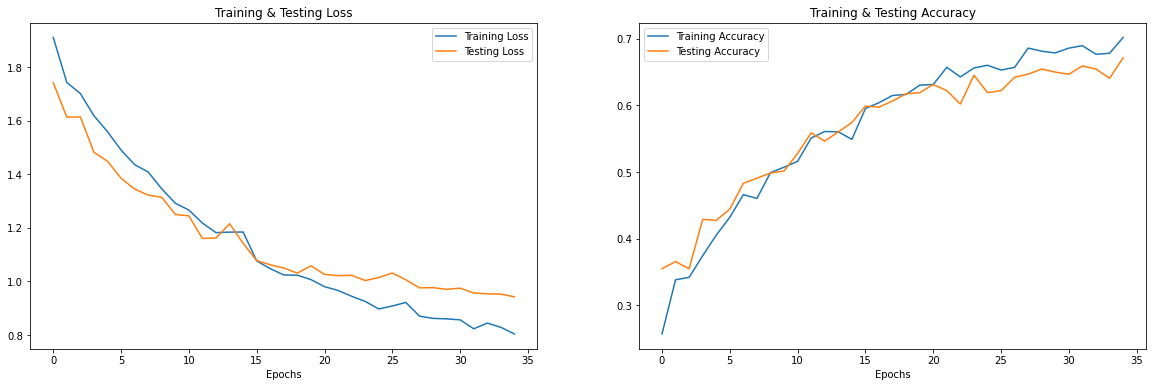

Random State : = 13
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 30ms/step - loss: 1.8980 - accuracy: 0.2547 - val_loss: 1.7401 - val_accuracy: 0.3432
Epoch 2/35
61/61 [==============================] - 1s 24ms/step - loss: 1.7523 - accuracy: 0.3247 - val_loss: 1.6524 - val_accuracy: 0.3877
Epoch 3/35
61/61 [==============================] - 1s 23ms/step - loss: 1.6670 - accuracy: 0.3510 - val_loss: 1.5523 - val_accuracy: 0.4173
Epoch 4/35
61/61 [==============================] - 1s 24ms/step - loss: 1.5821 - accuracy: 0.3897 - val_loss: 1.4616 - val_accuracy: 0.4630
Epoch 5/35
61/61 [==============================] - 1s 24ms/step - loss: 1.5031 - accuracy: 0.4317 - val_loss: 1.3864 - val_accuracy: 0.5062
Epoch 6/35
61/61 [==============================] - 1s 23ms/step - loss: 1.4640 - accuracy: 0.4465 - val_loss: 1.3

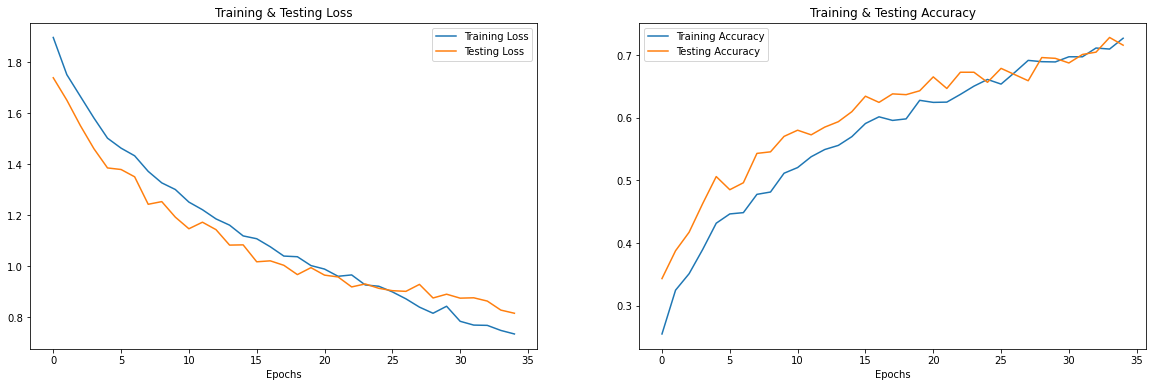

Random State : = 13
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 3s 38ms/step - loss: 1.8845 - accuracy: 0.2531 - val_loss: 1.7264 - val_accuracy: 0.2882
Epoch 2/35
65/65 [==============================] - 4s 55ms/step - loss: 1.7274 - accuracy: 0.3449 - val_loss: 1.5871 - val_accuracy: 0.3935
Epoch 3/35
65/65 [==============================] - 3s 46ms/step - loss: 1.6240 - accuracy: 0.3893 - val_loss: 1.4860 - val_accuracy: 0.4479
Epoch 4/35
65/65 [==============================] - 1s 23ms/step - loss: 1.5337 - accuracy: 0.4151 - val_loss: 1.3837 - val_accuracy: 0.4826
Epoch 5/35
65/65 [==============================] - 2s 25ms/step - loss: 1.4640 - accuracy: 0.4406 - val_loss: 1.3150 - val_accuracy: 0.5150
Epoch 6/35
65/65 [==============================] - 2s 23ms/step - loss: 1.4109 - accuracy: 0.4772 - val_loss: 1.2

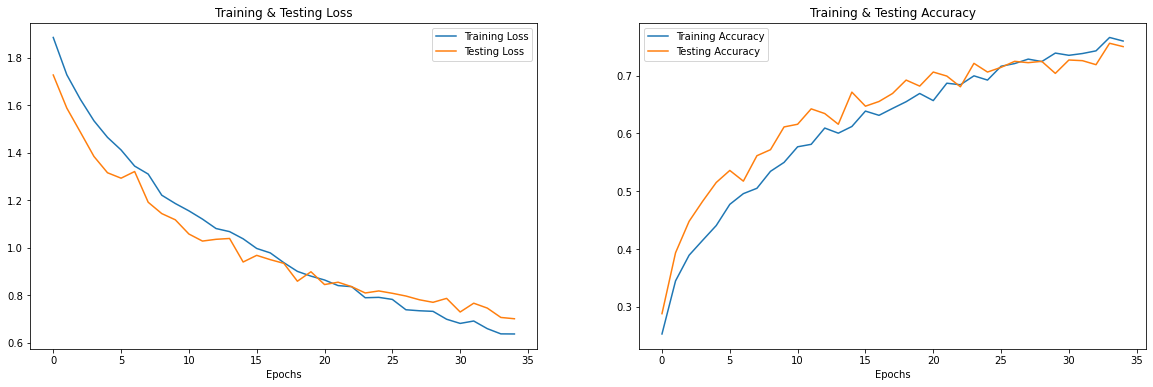

Random State : = 17
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 41ms/step - loss: 1.8974 - accuracy: 0.2494 - val_loss: 1.7399 - val_accuracy: 0.3556
Epoch 2/35
41/41 [==============================] - 1s 26ms/step - loss: 1.7558 - accuracy: 0.3370 - val_loss: 1.6464 - val_accuracy: 0.4222
Epoch 3/35
41/41 [==============================] - 1s 28ms/step - loss: 1.6525 - accuracy: 0.3883 - val_loss: 1.5694 - val_accuracy: 0.4019
Epoch 4/35
41/41 [==============================] - 1s 24ms/step - loss: 1.6339 - accuracy: 0.3802 - val_loss: 1.4992 - val_accuracy: 0.4667
Epoch 5/35
41/41 [==============================] - 1s 26ms/step - loss: 1.5429 - accuracy: 0.4136 - val_loss: 1.4395 - val_accuracy: 0.4944
Epoch 6/35
41/41 [==============================] - 1s 24ms/step - loss: 1.5007 - accuracy: 0.4346 - val_loss: 1.4

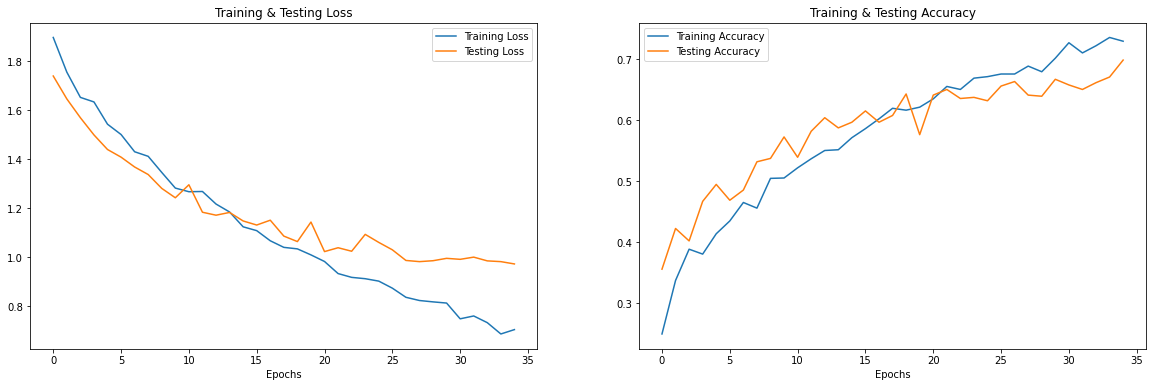

Random State : = 17
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 28ms/step - loss: 1.9118 - accuracy: 0.2629 - val_loss: 1.7535 - val_accuracy: 0.3380
Epoch 2/35
49/49 [==============================] - 2s 41ms/step - loss: 1.7537 - accuracy: 0.3272 - val_loss: 1.6219 - val_accuracy: 0.3920
Epoch 3/35
49/49 [==============================] - 1s 26ms/step - loss: 1.6460 - accuracy: 0.3781 - val_loss: 1.5218 - val_accuracy: 0.4352
Epoch 4/35
49/49 [==============================] - 1s 25ms/step - loss: 1.5730 - accuracy: 0.4084 - val_loss: 1.4808 - val_accuracy: 0.4398
Epoch 5/35
49/49 [==============================] - 1s 25ms/step - loss: 1.5147 - accuracy: 0.4259 - val_loss: 1.4353 - val_accuracy: 0.4738
Epoch 6/35
49/49 [==============================] - 2s 38ms/step - loss: 1.4632 - accuracy: 0.4537 - val_loss: 1.3

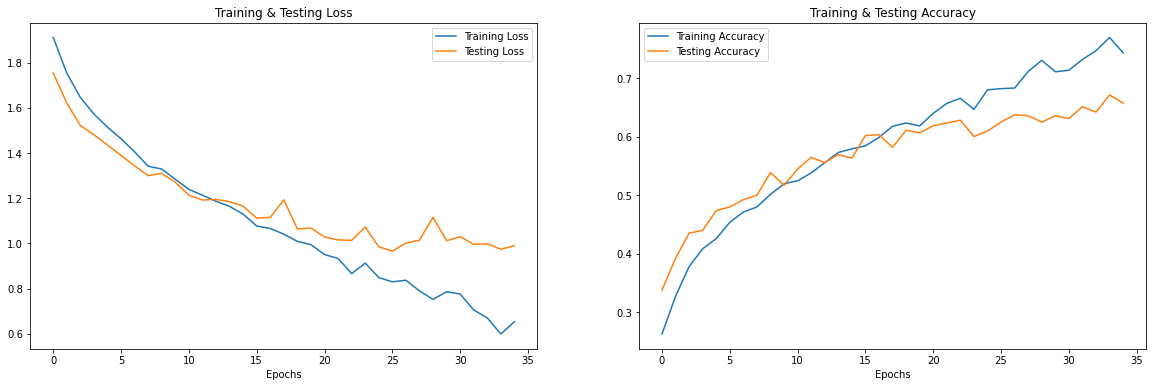

Random State : = 17
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 29ms/step - loss: 1.8916 - accuracy: 0.2638 - val_loss: 1.7746 - val_accuracy: 0.3346
Epoch 2/35
61/61 [==============================] - 2s 29ms/step - loss: 1.7623 - accuracy: 0.3218 - val_loss: 1.6559 - val_accuracy: 0.3901
Epoch 3/35
61/61 [==============================] - 2s 32ms/step - loss: 1.7006 - accuracy: 0.3588 - val_loss: 1.6027 - val_accuracy: 0.3889
Epoch 4/35
61/61 [==============================] - 2s 27ms/step - loss: 1.5904 - accuracy: 0.4033 - val_loss: 1.5522 - val_accuracy: 0.4086
Epoch 5/35
61/61 [==============================] - 1s 24ms/step - loss: 1.5384 - accuracy: 0.4313 - val_loss: 1.4294 - val_accuracy: 0.4457
Epoch 6/35
61/61 [==============================] - 2s 34ms/step - loss: 1.4762 - accuracy: 0.4325 - val_loss: 1.3

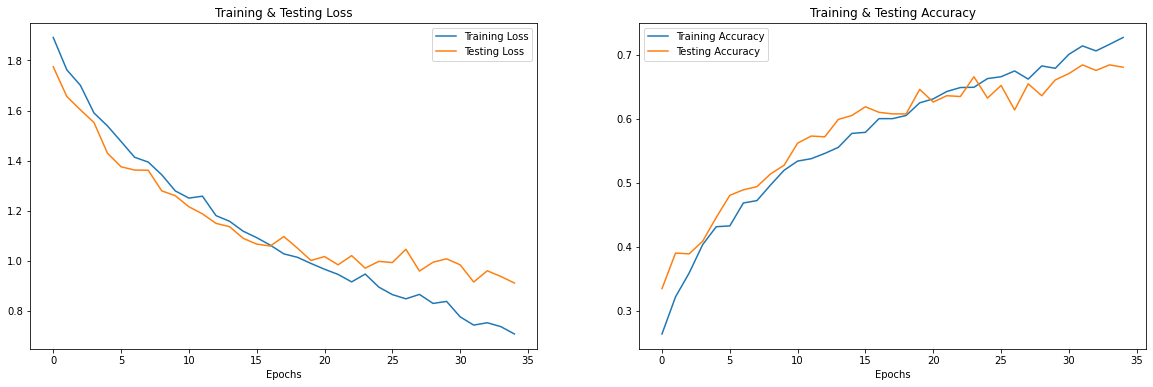

Random State : = 17
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 4s 54ms/step - loss: 1.9015 - accuracy: 0.2431 - val_loss: 1.7947 - val_accuracy: 0.3137
Epoch 2/35
65/65 [==============================] - 3s 51ms/step - loss: 1.7556 - accuracy: 0.3237 - val_loss: 1.6582 - val_accuracy: 0.3796
Epoch 3/35
65/65 [==============================] - 2s 32ms/step - loss: 1.6598 - accuracy: 0.3642 - val_loss: 1.5640 - val_accuracy: 0.4225
Epoch 4/35
65/65 [==============================] - 2s 25ms/step - loss: 1.5713 - accuracy: 0.3974 - val_loss: 1.4874 - val_accuracy: 0.4468
Epoch 5/35
65/65 [==============================] - 1s 22ms/step - loss: 1.5164 - accuracy: 0.4217 - val_loss: 1.4043 - val_accuracy: 0.4792
Epoch 6/35
65/65 [==============================] - 1s 23ms/step - loss: 1.4308 - accuracy: 0.4495 - val_loss: 1.3

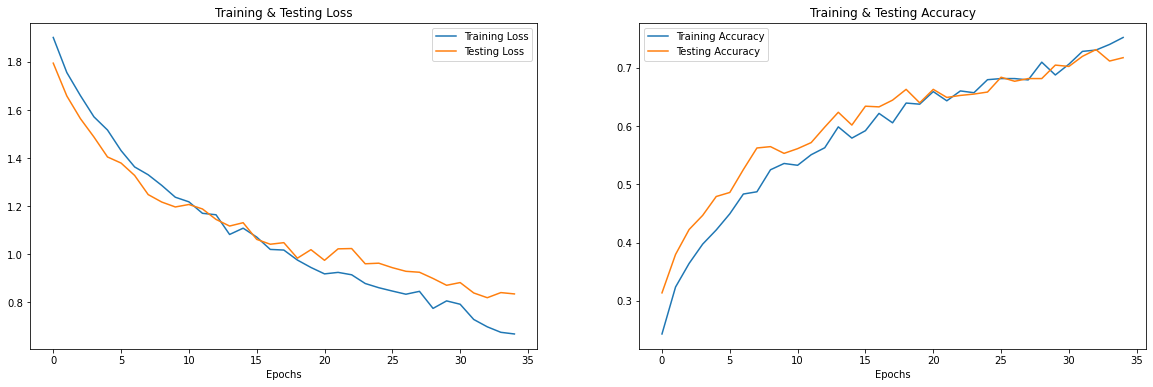

Random State : = 24
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 45ms/step - loss: 1.9823 - accuracy: 0.2407 - val_loss: 1.8905 - val_accuracy: 0.3074
Epoch 2/35
41/41 [==============================] - 2s 52ms/step - loss: 1.8418 - accuracy: 0.3049 - val_loss: 1.7494 - val_accuracy: 0.3685
Epoch 3/35
41/41 [==============================] - 2s 49ms/step - loss: 1.7574 - accuracy: 0.3352 - val_loss: 1.6413 - val_accuracy: 0.3889
Epoch 4/35
41/41 [==============================] - 2s 53ms/step - loss: 1.6918 - accuracy: 0.3778 - val_loss: 1.6180 - val_accuracy: 0.4185
Epoch 5/35
41/41 [==============================] - 2s 52ms/step - loss: 1.6454 - accuracy: 0.3963 - val_loss: 1.6062 - val_accuracy: 0.4222
Epoch 6/35
41/41 [==============================] - 2s 48ms/step - loss: 1.5628 - accuracy: 0.4222 - val_loss: 1.5

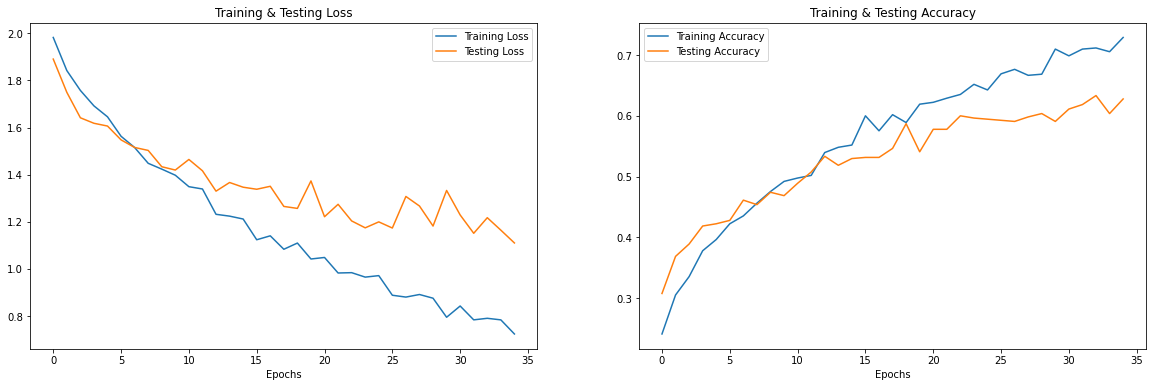

Random State : = 24
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 3s 49ms/step - loss: 1.9903 - accuracy: 0.1996 - val_loss: 1.8190 - val_accuracy: 0.3025
Epoch 2/35
49/49 [==============================] - 1s 23ms/step - loss: 1.8282 - accuracy: 0.2876 - val_loss: 1.6996 - val_accuracy: 0.3534
Epoch 3/35
49/49 [==============================] - 1s 23ms/step - loss: 1.7456 - accuracy: 0.3344 - val_loss: 1.6305 - val_accuracy: 0.3704
Epoch 4/35
49/49 [==============================] - 1s 23ms/step - loss: 1.6903 - accuracy: 0.3534 - val_loss: 1.5702 - val_accuracy: 0.4151
Epoch 5/35
49/49 [==============================] - 1s 23ms/step - loss: 1.6139 - accuracy: 0.3781 - val_loss: 1.5704 - val_accuracy: 0.4043
Epoch 6/35
49/49 [==============================] - 1s 24ms/step - loss: 1.5446 - accuracy: 0.4028 - val_loss: 1.5

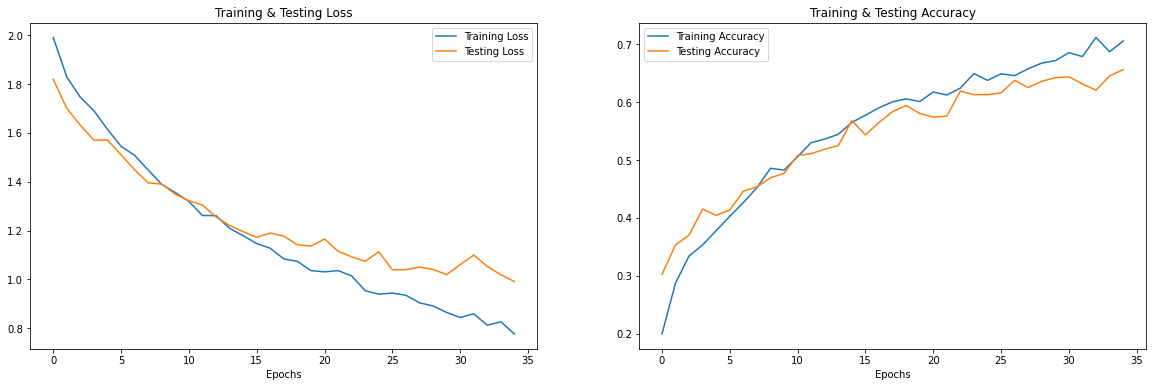

Random State : = 24
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 33ms/step - loss: 1.9218 - accuracy: 0.2486 - val_loss: 1.7276 - val_accuracy: 0.3667
Epoch 2/35
61/61 [==============================] - 3s 53ms/step - loss: 1.7583 - accuracy: 0.3325 - val_loss: 1.6687 - val_accuracy: 0.3654
Epoch 3/35
61/61 [==============================] - 3s 53ms/step - loss: 1.6199 - accuracy: 0.3914 - val_loss: 1.5617 - val_accuracy: 0.4062
Epoch 4/35
61/61 [==============================] - 3s 54ms/step - loss: 1.5496 - accuracy: 0.4128 - val_loss: 1.4931 - val_accuracy: 0.4370
Epoch 5/35
61/61 [==============================] - 3s 49ms/step - loss: 1.4696 - accuracy: 0.4358 - val_loss: 1.4446 - val_accuracy: 0.4815
Epoch 6/35
61/61 [==============================] - 3s 54ms/step - loss: 1.4143 - accuracy: 0.4770 - val_loss: 1.4

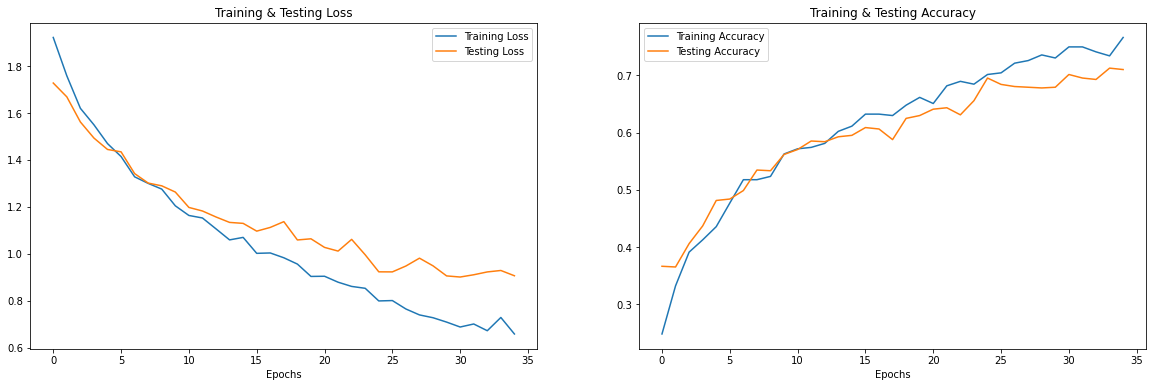

Random State : = 24
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 2s 28ms/step - loss: 1.9116 - accuracy: 0.2573 - val_loss: 1.7678 - val_accuracy: 0.3299
Epoch 2/35
65/65 [==============================] - 2s 31ms/step - loss: 1.7328 - accuracy: 0.3380 - val_loss: 1.6154 - val_accuracy: 0.3877
Epoch 3/35
65/65 [==============================] - 1s 22ms/step - loss: 1.6447 - accuracy: 0.3727 - val_loss: 1.5286 - val_accuracy: 0.4271
Epoch 4/35
65/65 [==============================] - 1s 23ms/step - loss: 1.5435 - accuracy: 0.4174 - val_loss: 1.5314 - val_accuracy: 0.4317
Epoch 5/35
65/65 [==============================] - 1s 23ms/step - loss: 1.4930 - accuracy: 0.4433 - val_loss: 1.4511 - val_accuracy: 0.4688
Epoch 6/35
65/65 [==============================] - 1s 23ms/step - loss: 1.4491 - accuracy: 0.4576 - val_loss: 1.4

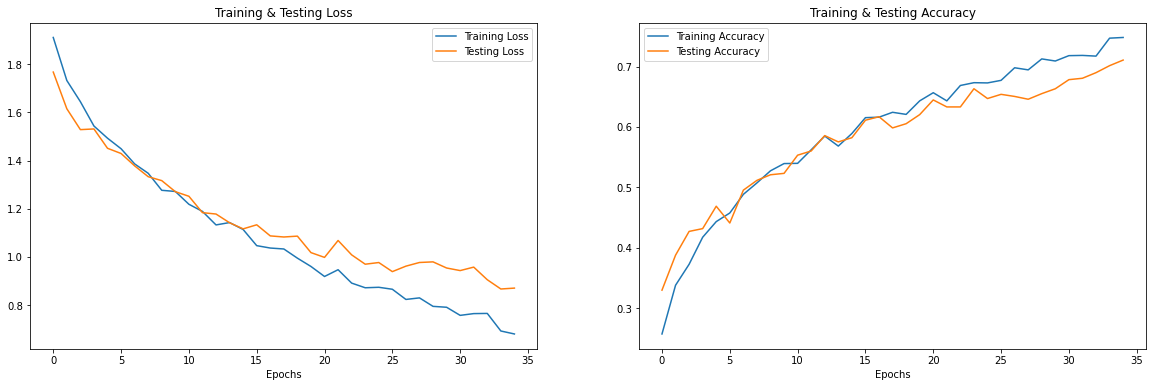

Random State : = 51
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 46ms/step - loss: 1.9668 - accuracy: 0.2006 - val_loss: 1.8693 - val_accuracy: 0.3352
Epoch 2/35
41/41 [==============================] - 1s 23ms/step - loss: 1.8194 - accuracy: 0.2883 - val_loss: 1.7903 - val_accuracy: 0.3574
Epoch 3/35
41/41 [==============================] - 2s 55ms/step - loss: 1.7566 - accuracy: 0.3296 - val_loss: 1.6758 - val_accuracy: 0.3722
Epoch 4/35
41/41 [==============================] - 2s 52ms/step - loss: 1.7125 - accuracy: 0.3204 - val_loss: 1.6506 - val_accuracy: 0.4019
Epoch 5/35
41/41 [==============================] - 1s 23ms/step - loss: 1.6256 - accuracy: 0.3593 - val_loss: 1.6236 - val_accuracy: 0.4167
Epoch 6/35
41/41 [==============================] - 1s 23ms/step - loss: 1.6236 - accuracy: 0.3685 - val_loss: 1.5

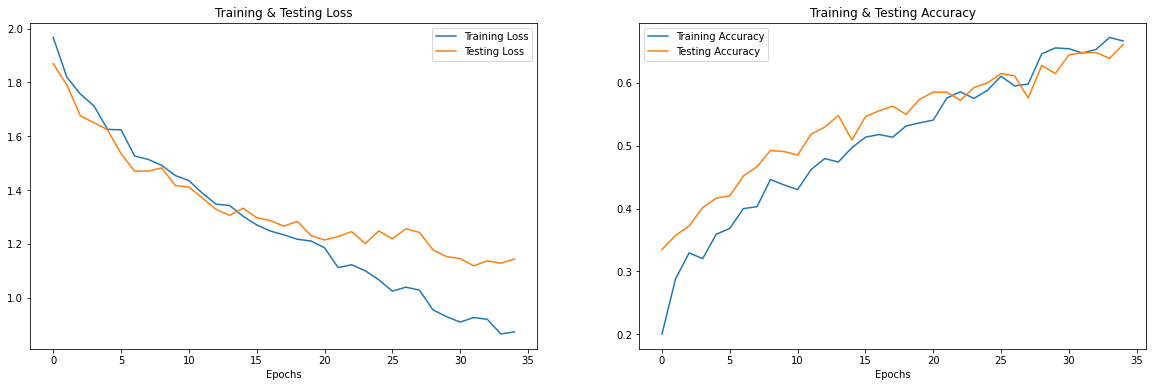

Random State : = 51
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 3s 44ms/step - loss: 1.9507 - accuracy: 0.2459 - val_loss: 1.8292 - val_accuracy: 0.3380
Epoch 2/35
49/49 [==============================] - 1s 23ms/step - loss: 1.7796 - accuracy: 0.3184 - val_loss: 1.6310 - val_accuracy: 0.4012
Epoch 3/35
49/49 [==============================] - 1s 27ms/step - loss: 1.6676 - accuracy: 0.3606 - val_loss: 1.5486 - val_accuracy: 0.4167
Epoch 4/35
49/49 [==============================] - 1s 26ms/step - loss: 1.5932 - accuracy: 0.3966 - val_loss: 1.4629 - val_accuracy: 0.4599
Epoch 5/35
49/49 [==============================] - 1s 24ms/step - loss: 1.4881 - accuracy: 0.4249 - val_loss: 1.3742 - val_accuracy: 0.4954
Epoch 6/35
49/49 [==============================] - 1s 26ms/step - loss: 1.4512 - accuracy: 0.4496 - val_loss: 1.3

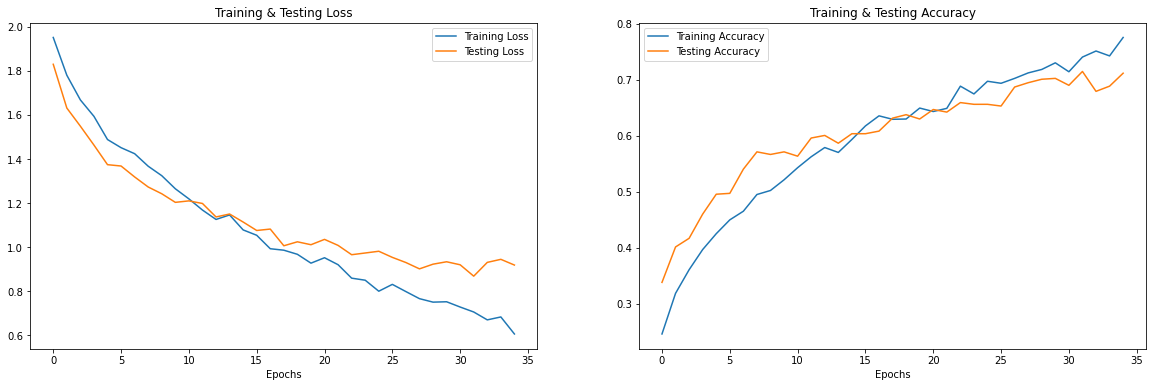

Random State : = 51
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 33ms/step - loss: 1.9202 - accuracy: 0.2420 - val_loss: 1.7773 - val_accuracy: 0.3370
Epoch 2/35
61/61 [==============================] - 2s 28ms/step - loss: 1.7256 - accuracy: 0.3358 - val_loss: 1.6131 - val_accuracy: 0.4148
Epoch 3/35
61/61 [==============================] - 2s 25ms/step - loss: 1.6160 - accuracy: 0.3827 - val_loss: 1.5085 - val_accuracy: 0.4198
Epoch 4/35
61/61 [==============================] - 1s 25ms/step - loss: 1.5705 - accuracy: 0.3988 - val_loss: 1.4570 - val_accuracy: 0.4370
Epoch 5/35
61/61 [==============================] - 1s 24ms/step - loss: 1.5046 - accuracy: 0.4350 - val_loss: 1.4120 - val_accuracy: 0.4667
Epoch 6/35
61/61 [==============================] - 2s 28ms/step - loss: 1.4419 - accuracy: 0.4498 - val_loss: 1.4

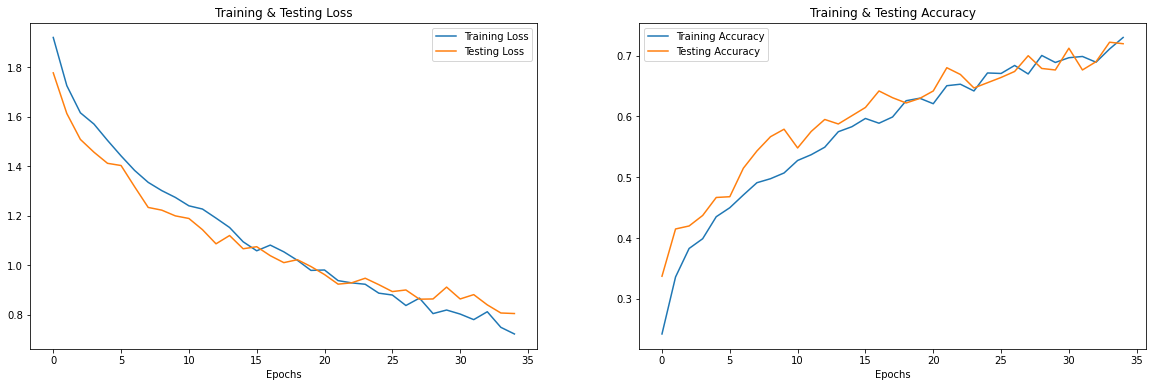

Random State : = 51
-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 4s 55ms/step - loss: 1.9255 - accuracy: 0.2230 - val_loss: 1.7916 - val_accuracy: 0.2986
Epoch 2/35
65/65 [==============================] - 3s 39ms/step - loss: 1.7711 - accuracy: 0.3110 - val_loss: 1.6486 - val_accuracy: 0.3773
Epoch 3/35
65/65 [==============================] - 3s 48ms/step - loss: 1.6853 - accuracy: 0.3326 - val_loss: 1.5867 - val_accuracy: 0.4155
Epoch 4/35
65/65 [==============================] - 2s 28ms/step - loss: 1.6167 - accuracy: 0.3765 - val_loss: 1.5007 - val_accuracy: 0.4363
Epoch 5/35
65/65 [==============================] - 2s 31ms/step - loss: 1.5436 - accuracy: 0.4186 - val_loss: 1.4385 - val_accuracy: 0.4641
Epoch 6/35
65/65 [==============================] - 2s 24ms/step - loss: 1.5114 - accuracy: 0.4132 - val_loss: 1.4

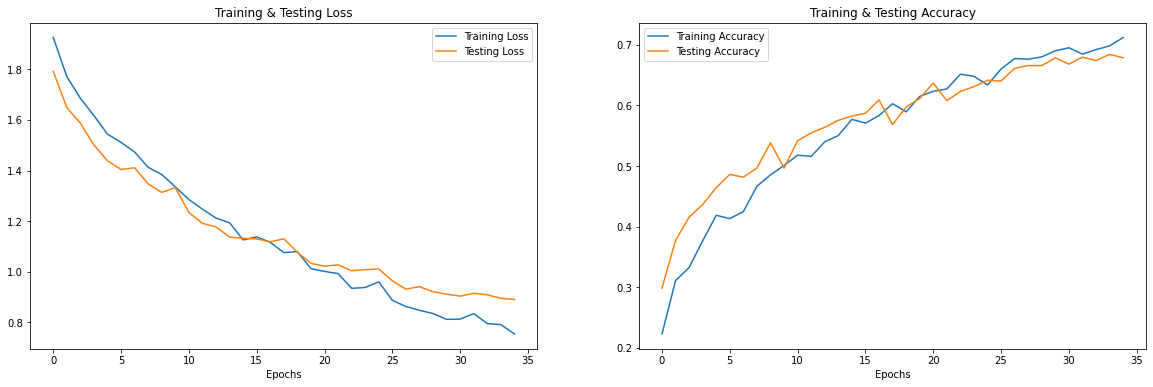

In [63]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_train_test_xy(),total=5):
    Model_1_dict = {}
    Histories_1 = {}
    for k in cg:
        Model_1_dict[k] = model_1(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Histories_1[k] = Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    # verbose=0,
                                    callbacks=[rlrp])
        
        
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        
        model_1_acc_matrix[k].append(loss_accuracy_details(Model_1_dict[k],
                                                           Histories_1[k],
                                                           epoch,x_tests[k],
                                                           y_tests[k]
                                                           ))
        
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1',k))
        Model_1_dict[k].save(os.path.join("Models",'model_1',k,f"model_1_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [64]:
model_1_acc_Df = pd.DataFrame(model_1_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
model_1_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'model_1_acc_mat.csv'))
model_1_acc_Df.head()

,10,13,17,24,51
a,59.583336,64.351851,65.185183,62.314814,61.944443
b,58.622688,64.467591,65.393519,65.856481,69.560188
c,62.685186,65.648150,65.092593,66.851854,67.685187
d,68.402779,70.023149,66.087961,68.750000,66.319442


In [68]:
model_1_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,62.675925,64.780093,65.592594,67.916666
std,2.198561,3.949541,1.915123,1.678043
min,59.583336,58.622688,62.685186,66.087961
25%,61.944443,64.467591,65.092593,66.319442
50%,62.314814,65.393519,65.648150,68.402779
75%,64.351851,65.856481,66.851854,68.750000
max,65.185183,69.560188,67.685187,70.023149


----
# Model 2
----

In [77]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_2')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_2'))

In [76]:
Model_2_dict = {}
Histories_2 = {}

In [79]:
def model_2(x_train):
    model=Sequential()
    model.add(Conv1D(128, kernel_size=7, strides=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 2, padding = 'same'))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [80]:
Model_2_dict = {}
for k in cg:
    Model_2_dict[k] = model_2(x_trains[k])

In [83]:
for k in cg:
    print("-------------------")
    print(f"Traing is going on for Model 2")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Histories_2[k] = Model_2_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_2_dict[k].save(os.path.join("Models",'model_2',f"model_2_{'_'.join(TTS_DICT[k])}.h5"))

-------------------
Traing is going on for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
26/26 [==============================] - 1s 28ms/step - loss: 1.9935 - accuracy: 0.1914 - val_loss: 1.8731 - val_accuracy: 0.2722
Epoch 2/40
26/26 [==============================] - 0s 8ms/step - loss: 1.8834 - accuracy: 0.2500 - val_loss: 1.8050 - val_accuracy: 0.3019
Epoch 3/40
26/26 [==============================] - 0s 9ms/step - loss: 1.8045 - accuracy: 0.2728 - val_loss: 1.7169 - val_accuracy: 0.3130
Epoch 4/40
26/26 [==============================] - 0s 7ms/step - loss: 1.7257 - accuracy: 0.3222 - val_loss: 1.6388 - val_accuracy: 0.3611
Epoch 5/40
26/26 [==============================] - 0s 18ms/step - loss: 1.6508 - accuracy: 0.3679 - val_loss: 1.5989 - val_accuracy: 0.3704
Epoch 6/40
26/26 [==============================] - 0s 7ms/step - loss: 1.5922 - accuracy: 0.3988 - val_loss: 1.5639 - val_accuracy: 

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
68/68 [==============================] - 0s 2ms/step - loss: 1.0090 - accuracy: 0.7023
Accuracy of our model on test data :  70.23147940635681 %


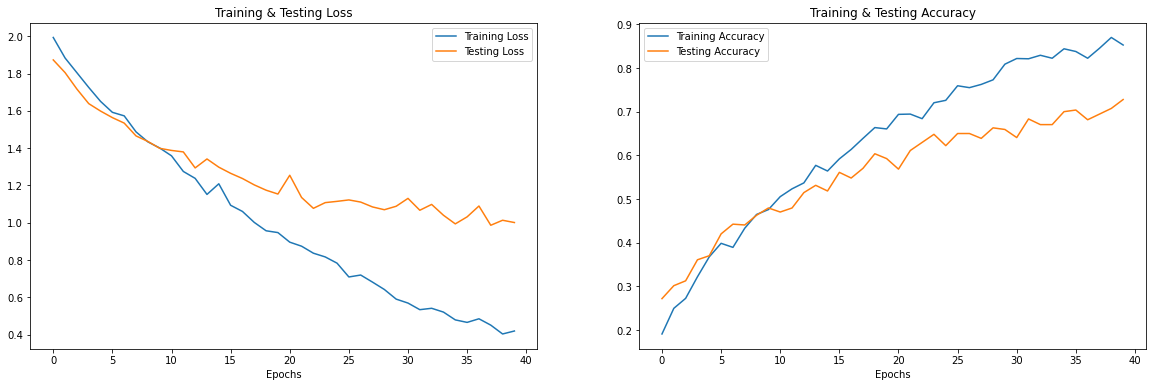

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
54/54 [==============================] - 0s 4ms/step - loss: 0.8330 - accuracy: 0.7541
Accuracy of our model on test data :  75.40509104728699 %


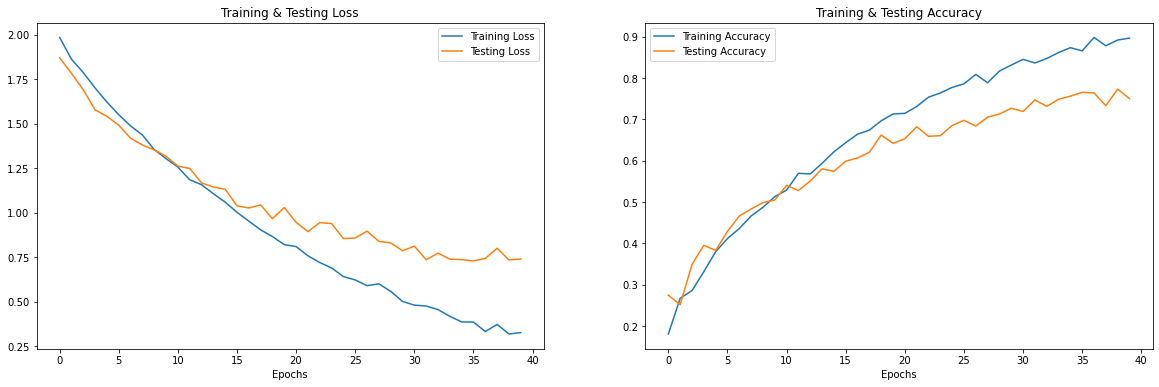

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
27/27 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.7859
Accuracy of our model on test data :  78.58796119689941 %


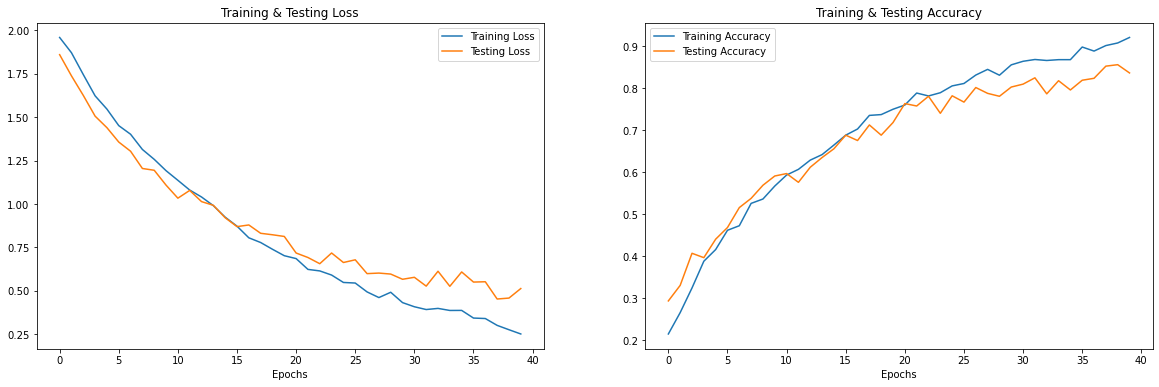

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
34/34 [==============================] - 0s 2ms/step - loss: 0.6246 - accuracy: 0.8037
Accuracy of our model on test data :  80.37037253379822 %


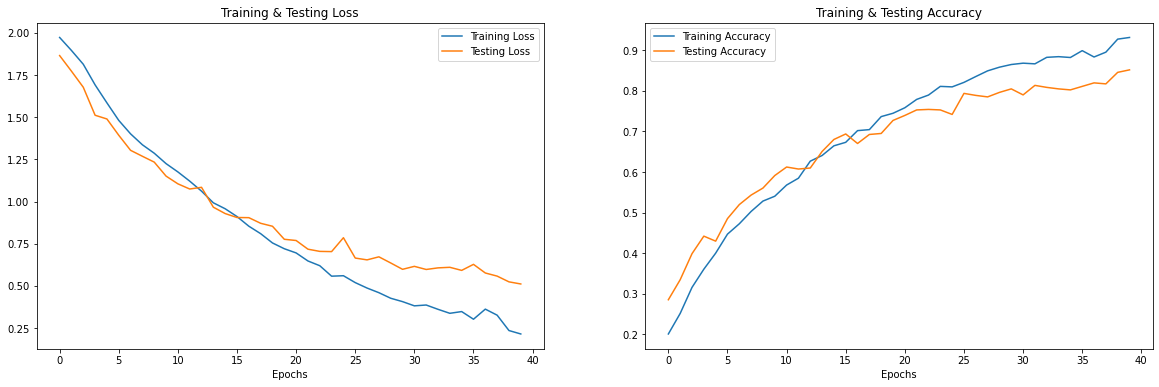

In [84]:
for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_2_dict[k],Histories_2[k],epoch,x_tests[k],y_tests[k])

---
# Model 3 Training Testing
---

In [90]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_3')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_3'))

In [91]:
Model_3_dict = {}
Histories_3 = {}

In [94]:
def model_3(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 3, padding = 'same'))

    model.add(Conv1D(256, kernel_size=9, strides=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 5, padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model


In [95]:
Model_3_dict = {}
for k in cg:
    Model_3_dict[k] = model_3(x_trains[k])

In [96]:
for k in cg:
    print("-------------------")
    print(f"Traing is going on for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Histories_3[k] = Model_3_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_3_dict[k].save(os.path.join("Models",'model_3',f"model_3_{'_'.join(TTS_DICT[k])}.h5"))

-------------------
Traing is going on for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
26/26 [==============================] - 2s 53ms/step - loss: 1.9615 - accuracy: 0.2154 - val_loss: 1.8267 - val_accuracy: 0.3259
Epoch 2/40
26/26 [==============================] - 1s 56ms/step - loss: 1.8013 - accuracy: 0.3117 - val_loss: 1.7263 - val_accuracy: 0.3463
Epoch 3/40
26/26 [==============================] - 1s 53ms/step - loss: 1.6860 - accuracy: 0.3593 - val_loss: 1.6361 - val_accuracy: 0.4426
Epoch 4/40
26/26 [==============================] - 1s 52ms/step - loss: 1.5809 - accuracy: 0.4086 - val_loss: 1.5186 - val_accuracy: 0.4389
Epoch 5/40
26/26 [==============================] - 1s 43ms/step - loss: 1.5302 - accuracy: 0.4136 - val_loss: 1.4821 - val_accuracy: 0.4407
Epoch 6/40
26/26 [==============================] - 1s 43ms/step - loss: 1.4437 - accuracy: 0.4562 - val_loss: 1.4163 - val_accura

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
68/68 [==============================] - 0s 6ms/step - loss: 1.1036 - accuracy: 0.7657
Accuracy of our model on test data :  76.57407522201538 %


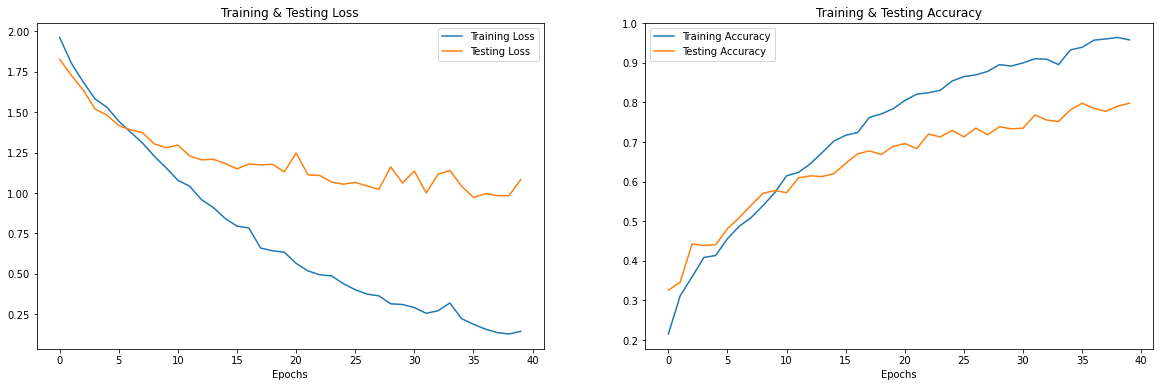

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
54/54 [==============================] - 0s 6ms/step - loss: 0.8047 - accuracy: 0.7870
Accuracy of our model on test data :  78.70370149612427 %


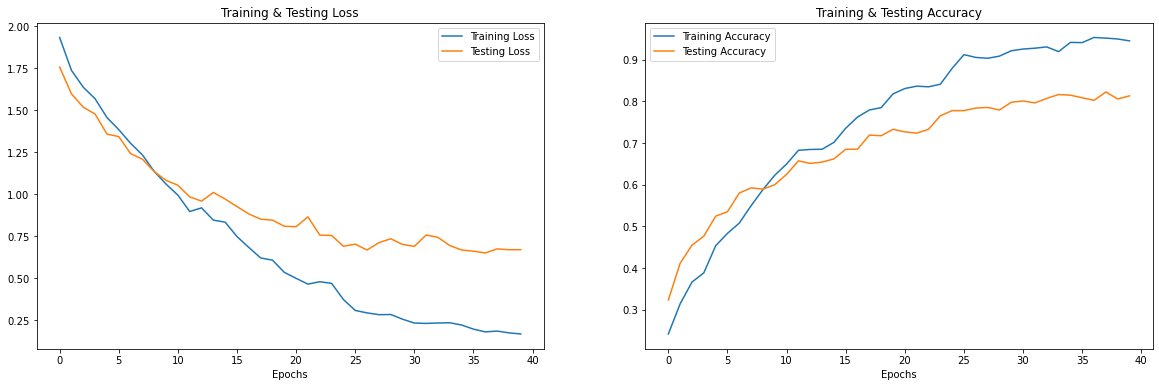

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
27/27 [==============================] - 0s 8ms/step - loss: 0.5519 - accuracy: 0.8426
Accuracy of our model on test data :  84.25925970077515 %


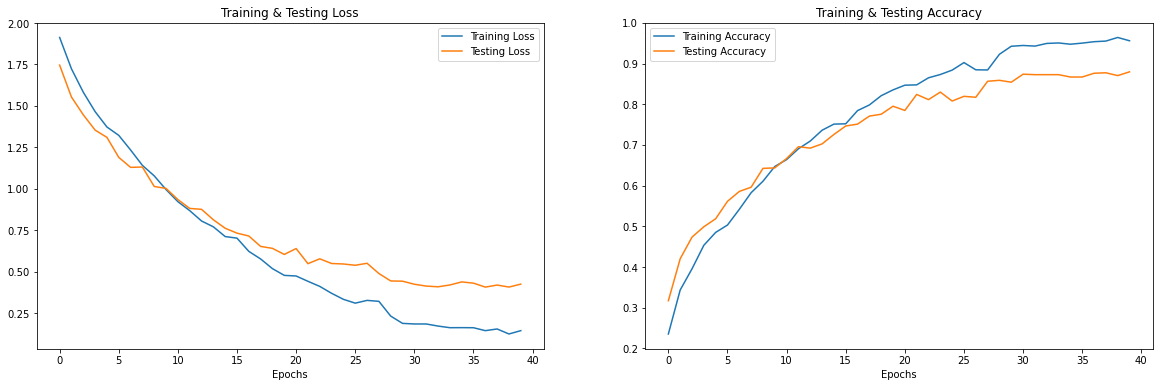

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
34/34 [==============================] - 0s 5ms/step - loss: 0.6091 - accuracy: 0.8444
Accuracy of our model on test data :  84.44444537162781 %


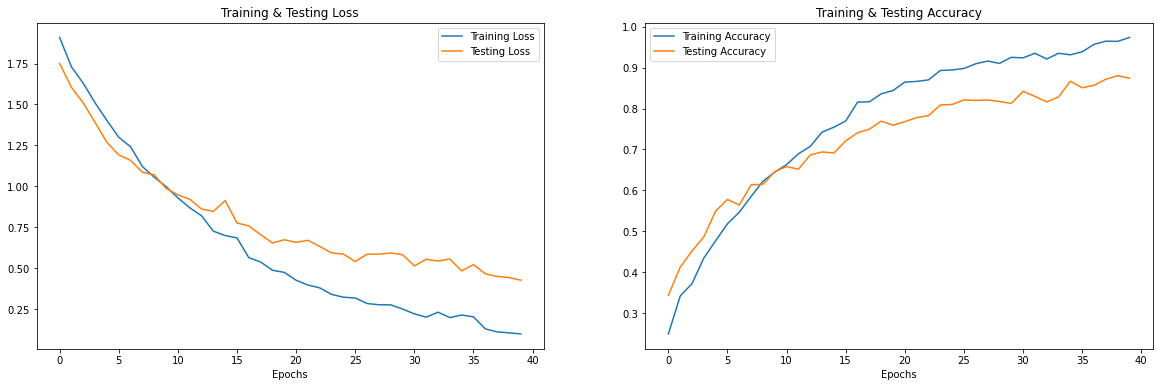

In [97]:
for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_3_dict[k],Histories_3[k],epoch,x_tests[k],y_tests[k])